In [5]:
import os
import cv2
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from skimage.metrics import peak_signal_noise_ratio
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.optimizers import Adam
from google.colab.patches import cv2_imshow

def apply_median_filter(img):
    return cv2.medianBlur(img, 3)

def apply_mean_filter(img):
    return cv2.blur(img, (3, 3))

def apply_gaussian_filter(img):
    return cv2.GaussianBlur(img, (3, 3), 0)

def apply_bilateral_filter(img):
    return cv2.bilateralFilter(img, 5, 75, 75)

def get_psnr(original, processed):
    mse = np.mean((original - processed) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 255.0
    psnr = 10 * np.log10((max_pixel ** 2) / mse)
    return psnr

def add_poisson(img, lambda_val):
  poisson_noise = np.random.poisson(lambda_val, size=img.shape)
  noisy_image = img + poisson_noise
  if noisy_image.dtype != np.uint8:
    noisy_image = cv2.convertScaleAbs(noisy_image)
  return noisy_image

# Get the images in the pneumonia folder
data_folder = "/content/pneumonia/"
image_files = [os.path.join(data_folder, f) for f in os.listdir(data_folder) if f.endswith('.jpeg')]
images = [cv2.imread(file, cv2.IMREAD_GRAYSCALE) for file in image_files]

input_size = (124, 124)
images_resized = [cv2.resize(img, input_size) for img in images]
images_resized = np.array(images_resized)

train_images, test_images = train_test_split(images_resized, test_size=0.2, random_state=42)
train_images = tf.convert_to_tensor(train_images, dtype=tf.float32)
test_images = tf.convert_to_tensor(test_images, dtype=tf.float32)

# Autoencoder
def create_autoencoder(input_shape, z):
    input_img = Input(shape=input_shape)
    # Encoder
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(z, (3, 3), activation='relu', padding='same')(x)  # Use latent_dim here
    encoded = MaxPooling2D((2, 2), padding='same', name='bottleneck')(x)  # Adding a name to the bottleneck layer
    # Decoder
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('bottleneck').output)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

    return autoencoder, encoder

def encode(image):
    return encoder.predict(image)

lambda_values = [25, 50, 75]
noisy_images_list = []
for lambda_value in lambda_values:
    noisy_images = []
    for image in images_resized:
        noisy_image = add_poisson(image, lambda_value)
        noisy_images.append(noisy_image)
    noisy_images_list.append(noisy_images)

average_psnr_values = {}
input_shape = (124, 124, 1)
latent_dim = 32
for idx, lambda_value in enumerate(lambda_values):
    autoencoder, encoder = create_autoencoder(input_shape, latent_dim)  # Create autoencoder with specified input shape and latent dimension
    noisy_images = np.array(noisy_images_list[idx])
    autoencoder.fit(noisy_images, images_resized, epochs=100, batch_size=10, shuffle=True, validation_split=0.2)

    autoencoder.save_weights('autoencoder_weights.h5')

    psnr_values_autoencoder = []
    psnr_values_median = []
    psnr_values_mean = []
    psnr_values_gaussian = []
    psnr_values_bilateral = []

    for test_image in test_images:
        denoised_image_autoencoder = autoencoder.predict(test_image[np.newaxis, ...])[0, ...]
        psnr_autoencoder = get_psnr(test_image, denoised_image_autoencoder)
        psnr_values_autoencoder.append(psnr_autoencoder)

        noisy_image = test_image.numpy()
        denoised_image_median = apply_median_filter(noisy_image)
        denoised_image_mean = apply_mean_filter(noisy_image)
        denoised_image_gaussian = apply_gaussian_filter(noisy_image)
        denoised_image_bilateral = apply_bilateral_filter(noisy_image)

        psnr_median = get_psnr(test_image, denoised_image_median)
        psnr_mean = get_psnr(test_image, denoised_image_mean)
        psnr_gaussian = get_psnr(test_image, denoised_image_gaussian)
        psnr_bilateral = get_psnr(test_image, denoised_image_bilateral)

        psnr_values_median.append(psnr_median)
        psnr_values_mean.append(psnr_mean)
        psnr_values_gaussian.append(psnr_gaussian)
        psnr_values_bilateral.append(psnr_bilateral)

    average_psnr_values[lambda_value] = {
        "Autoencoder": np.mean(psnr_values_autoencoder),
        "Median Filter": np.mean(psnr_values_median),
        "Mean Filter": np.mean(psnr_values_mean),
        "Gaussian Filter": np.mean(psnr_values_gaussian),
        "Bilateral Filter": np.mean(psnr_values_bilateral)
    }

# Print average PSNR values for each lambda value
for lambda_value, psnr_values in average_psnr_values.items():
    print(f"Lambda value: {lambda_value}")
    print(f"Average PSNR values:")
    for method, average_psnr in psnr_values.items():
        print(f"{method}: {average_psnr:.2f}")

encoded_z_values = []
for train_image in train_images:
    encoded_image = encode(train_image[np.newaxis, ...])
    encoded_z_values.append(encoded_image.flatten())  # Flatten the encoded image to store as a 1D array

    # Convert the list of encoded z values into a pandas DataFrame
    encoded_df = pd.DataFrame(encoded_z_values)

    # Save the data to a csv file
    encoded_df.to_csv(f'z_values.csv', index=False)

Epoch 1/100
8/8 [==============================] - 5s 475ms/step - loss: -1616.8760 - val_loss: -1903.6166
Epoch 2/100
8/8 [==============================] - 3s 393ms/step - loss: -1902.7467 - val_loss: -1903.9375
Epoch 3/100
8/8 [==============================] - 4s 532ms/step - loss: -1902.7966 - val_loss: -1903.9437
Epoch 4/100
8/8 [==============================] - 3s 294ms/step - loss: -1902.7979 - val_loss: -1903.9446
Epoch 5/100
8/8 [==============================] - 3s 358ms/step - loss: -1902.7979 - val_loss: -1903.9446
Epoch 6/100
8/8 [==============================] - 3s 386ms/step - loss: -1902.7976 - val_loss: -1903.9446
Epoch 7/100
8/8 [==============================] - 2s 286ms/step - loss: -1902.7979 - val_loss: -1903.9446
Epoch 8/100
8/8 [==============================] - 2s 220ms/step - loss: -1902.7979 - val_loss: -1903.9446
Epoch 9/100
8/8 [==============================] - 3s 323ms/step - loss: -1902.7979 - val_loss: -1903.9446
Epoch 10/100
8/8 [===================

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


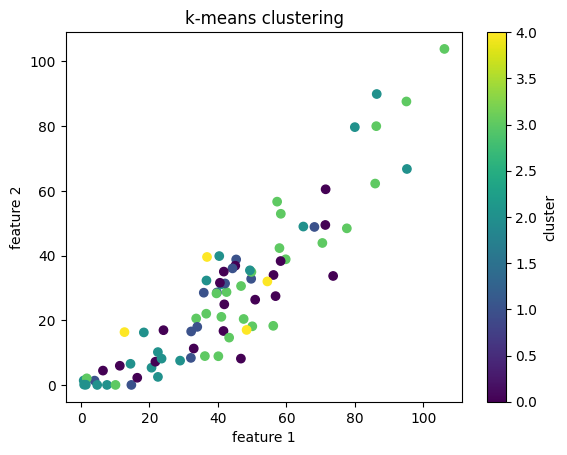

In [7]:
# Load the data from the csv file
data = pd.read_csv('z_values.csv', index_col=0)

# Perform K-means clustering
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(data)

plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=clusters, cmap='viridis')
plt.title('k-means clustering')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.colorbar(label='cluster')
plt.show()

For this particular task,  how did you measure how good your configuration for latent space dimensionality is? Make sure your answer follows the following criteria:

Objectively sound (computationally proven)

K-means clustering serves as a quantitative gauge of how well the encoded representations capture the intrinsic patterns within the data. As an unsupervised learning method, k-means clustering operates independently of labeled data, providing an impartial and data-centric assessment of the latent space configuration. The interpretability of the results allows for a deeper understanding of the underlying structure of the encoded representations. The interpretable clusters suggest that the latent space effectively captures significant features or variations within the data. Through the application of clustering analysis to the encoded representations, insights are gained regarding the efficacy of the selected latent space dimensionality configuration in representing the inherent structure of the data.

Explainable

We load the data from the csv file "z_values.csv" into a pandas DataFrame.
We then use K-means clustering to cluster the encoded representations into a predefined number of clusters. K-means clustering partitions the data into clusters so that each data point belongs to the cluster with the nearest mean.
We can now visualize the clustering results in a scatter plot. Each point represents an encoded representation, and its color indicates the assigned cluster.

References:

https://www.analyticsvidhya.com/blog/2019/08/comprehensive-guide-k-means-clustering/

https://www.w3schools.com/python/python_ml_k-means.asp

